In [212]:
import pandas as pd
from pathlib import Path
folder = Path('data')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rd_ticks = [1,33,65, 100, 137, 174, 214, 256]

## Contents

 - [data load](#Load)
   - primarily using OTC market data here: `data`
 - [group, gather performance data](#gather-position-data-+-performance)
   - group R/L for positions like Guard, Tackle
   - gather performance data (AVpG) from draft data: `draft`
     - cast wider position net to match players
 - [position market comparison graphs](#market-comparisons-for-positions)
   - overlaid linear fit
 - [position market explore - determine top contracts cutoffs](#top-contracts,-performance-fit)
   - cutoffs used in above comparison graphs
 - [other curve fitting code](#statsmodels-api-not-used-here)
   - used numpy polyfit for this notebook
   - see Analysis notebook for scipy

### Load

In [213]:
cap_history = pd.read_csv(Path(folder, 'salary_cap_history.csv'), index_col=0)
max_cap = cap_history[cap_history.Year==2023].Cap.values[0]
del cap_history
print(max_cap)

# cap table, pick vs salary cap percentage
cap = pd.read_csv(Path(folder, 'pick_cap_percentage.csv'), index_col=0)
# draft table
draft = pd.read_csv(Path(folder, 'draft_2011-2023.csv'), index_col=0)
# salary data
data = pd.read_csv(Path(folder, 'vet_contracts.csv'), index_col=0)

224800000


In [214]:
# draft adjustments, 2011 and after for CB agreement --> wagescale
draft = draft[draft.draft_year >= 2011]
draft.drop(columns = draft.columns[13:27], inplace=True)
draft.drop(columns=draft.columns[draft.columns.str.startswith('Misc_')], inplace=True)
draft.rename(columns={'Approx Val_wAV':'wAV', 'Approx Val_DrAV':'dAV', 'G':'Games','Uni':'College'}, inplace=True)

# clean negatives | draft.loc[[2744,3295,4251],:]
draft.loc[draft[draft.dAV<0].index, 'dAV'] = 0
draft.loc[draft[draft.wAV<0].index, 'wAV'] = 0

# normalize value by games played
draft.loc[:,'wAVpG'] = draft['wAV']/draft['Games']
draft.loc[:,'dAVpG'] = draft['dAV']/draft['Games']
# fill na with 0
draft['wAVpG'] = draft['wAVpG'].fillna(0)
draft['dAVpG'] = draft['dAVpG'].fillna(0)

# Change "To" to years played
draft.loc[:,'To'] = draft['To']-draft['draft_year']+1
draft.rename(columns={'To':'Yrs', 'draft_year':'Drafted'}, inplace=True)
draft.loc[draft[draft.Yrs<=0].index, 'Yrs'] = 0

# Convert single Pos==OT (AJ Arcuri) to T
draft.loc[draft[draft.Pos=='OT'].index,'Pos'] = 'T'

# Add Cap Percentage
draft.loc[:,'Cap'] = draft['Pick'].map(lambda x: cap.loc[x, 'Perc'])

### gather position data + performance
 - provide two lists to match data
   - group positions from OTC table (RT/LT)
   - match positions for PFR table (S: DB)
 - gather matched data, drop players not found from PFR table
   - filter guaranteed > 0
   - add percentile AVpG column

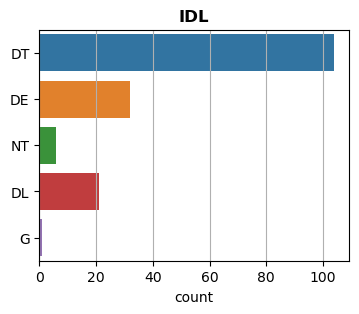

In [215]:
plt.figure(figsize=(4,3))
# Input position from OTC salary data and see matching positions from PFR draft data
check_pos = 'IDL'
check = []
for player in data[(data.Player.isin(draft.Player)) & (data.Pos==check_pos)].Player.values:
    check.append(draft[draft.Player==player].Pos.values[0])
    
sns.countplot(y=check)
plt.grid(axis='x')
plt.title(check_pos, fontweight='bold')
plt.show()

In [216]:
# group positions and extend groups for draft data labels
# need to do two groupings, otherwise overlaps in contract data will be fukt
pos_groups = {
    # OFFFENSE SKILL
    'QB':(['QB'],['QB']),
    'WR':(['WR'],['WR']),
    'TE':(['TE'],['TE']),
    'RB':(['RB','FB'], ['RB','FB']),
    # OFFENSE LINE
    'T':(['RT','LT'], ['T','OL','G','C']), 
    'G':(['RG','LG'], ['G','OL','T','C']),
    'C':(['C'], ['C','OL','T','G']),
    # SPECIAL TEAMS
    'ST':(['K','P','LS'], ['K','P','LS']),
    # DEFENSE SECONDARY
    'CB':(['CB'], ['CB','DB','S']),
    'S':(['S'], ['S','DB','CB']),
    # DEFENSE FRONT
    'EDGE':(['EDGE'], ['OLB','DE','LB','DL','DT']),
    'IDL':(['IDL'], ['DT','NT','DE','DL']),
    'LB':(['LB'], ['LB','ILB','OLB','S']),
}

In [217]:
market_tables = {}
pd.options.mode.chained_assignment = None

for key,(combine,match) in pos_groups.items():
    p = data[(data.Pos.isin(combine))&(data['Total Guaranteed']>0)]
    p.loc[:,'AVpG'] = p.Player.map(lambda x: draft[(draft.Player==x) & (draft.Pos.isin(match))].wAVpG.values)
    p.loc[:,'AVpG'] = p.AVpG.map(lambda x: x[0] if len(x)>0 else None)
    # save notable drops
    # top_drops = p[p.AVpG.isna()].head()

    # drop empty data, add other draft data
    p.dropna(inplace=True)
    p.loc[:,'Drafted'] = p.Player.map(lambda x: draft[(draft.Player==x) & (draft.Pos.isin(match))].Drafted.values)
    p.loc[:,'Drafted'] = p.Drafted.map(lambda x: int(x[0]) if len(x)>0 else None)
    p.loc[:,'Draft_Pick'] = p.Player.map(lambda x: draft[(draft.Player==x) & (draft.Pos.isin(match))].Pick.values)
    p.loc[:,'Draft_Pick'] = p.Draft_Pick.map(lambda x: int(x[0]) if len(x)>0 else None)


    # adjust dtypes, add percentile
    p.AVpG = p.AVpG.astype(float)
    p.loc[:,'AV_percentile'] = percentileofscore(draft[draft.Pos.isin(match)].wAVpG, p.AVpG,).round(1)

    market_tables[key] = p.reset_index(drop=True)

In [218]:
market_tables['EDGE'].head()

,Player,Pos,Tm,Total Value,APY,Total Guaranteed,AGY,% Guaranteed,APY_Cap,AVpG,Drafted,Draft_Pick,AV_percentile
0,Nick Bosa,EDGE,49ers,170000000,34000000,88000000,17600000,51.8,15.125,0.735294,2019,2,99.4
1,T.J. Watt,EDGE,Steelers,112011000,28002750,80000000,20000000,71.4,12.457,0.769231,2017,30,99.5
2,Joey Bosa,EDGE,Chargers,135000000,27000000,78000000,15600000,57.8,12.011,0.548387,2016,3,97.4
3,Myles Garrett,EDGE,Browns,125000000,25000000,50000000,10000000,40.0,11.121,0.800000,2017,1,99.7
4,Montez Sweat,EDGE,Bears,98000000,24500000,41965000,10491250,42.8,10.899,0.473684,2019,26,94.9


### market comparisons for positions
 - check groupings used for Data Analysis
   - DB: CB and S, iOL: G,C
 - OLine: C vs G vs T
 - OSkill: WR, RB, TE
 - WR vs CB, CB vs Edge
 - IDL vs EDGE vs LB

In [191]:
market_tables.keys()

dict_keys(['QB', 'WR', 'TE', 'RB', 'T', 'G', 'C', 'ST', 'CB', 'S', 'EDGE', 'IDL', 'LB'])

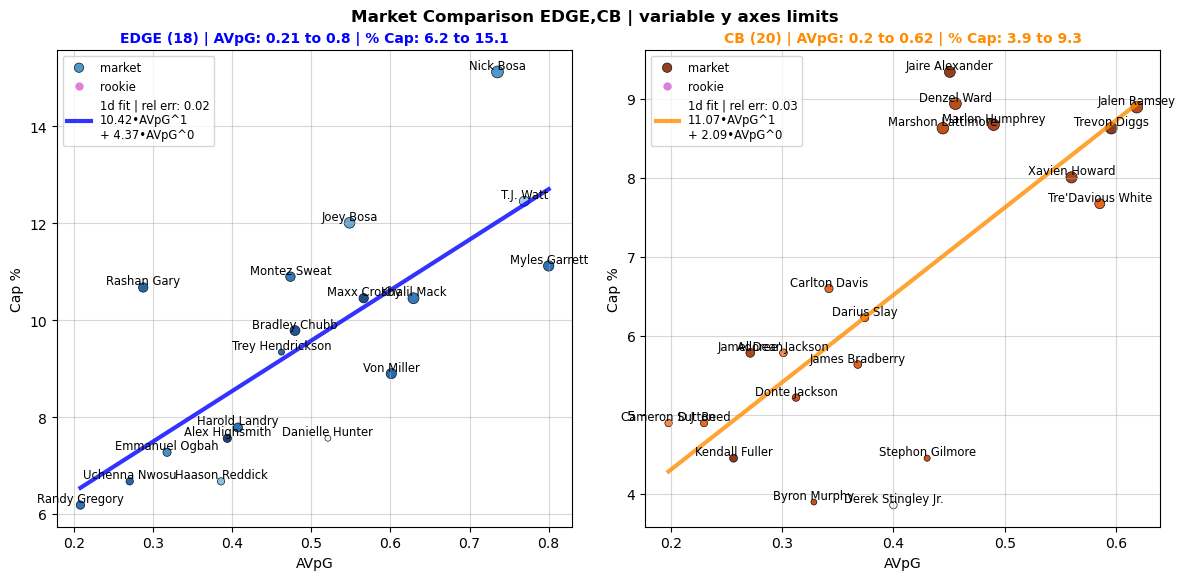

In [219]:
positions = ['EDGE','CB',]
cutoffs = [18, 20]
degs = [1,1,1]
colors = ['b','darkorange','green', 'purple', 'r']
cmaps = ['Blues','Oranges','Greens','Purples','Reds']

x_col = 'AV_percentile'
x_col = 'AVpG'
plt.figure(figsize=(4+4*len(positions), 6), dpi=100, layout='tight')
leg_text = []
consistent_y_axis = False

for i,pos in enumerate(positions):
    if i == 0 or consistent_y_axis==False:
        ax = plt.subplot(int(f'1{len(positions)}{i+1}'))
    else:
        ax = plt.subplot(int(f'1{len(positions)}{i+1}'), sharey=ax)
    d = market_tables[pos].copy().head(cutoffs[i])
    vet = d[d.Drafted!=2023]
    
    # Vets
    sns.scatterplot(vet, y='APY_Cap', x=x_col, hue='% Guaranteed', palette=f'{cmaps[i]}_r',
            size='Total Value', legend=False, alpha=0.9, 
            edgecolor='k', linewidth=0.5, ax=ax)
    # Rookies
    ax.scatter(data = d[~d.index.isin(vet.index)], x=x_col, y='APY_Cap', 
                color='m', alpha=0.5, linewidths=0)  
    for x,y,name,player_position in d[[x_col,'APY_Cap','Player','Pos']].values:
        #name = name.split(' ')[-1]
        if pos=='ST':
            name = f'{name} ({player_position})'
        ax.text(x,y,name, fontsize='small', ha='center', va='bottom')
    
    x = np.linspace(vet[x_col].min(), vet[x_col].max())
    px = np.polyfit(vet[x_col], vet.APY_Cap, degs[i],  full=True)
    poly_fit = (px[0],px[1][0], degs[i]) 
    ax.plot(x, np.poly1d(poly_fit[0])(x),'-', linewidth=3, alpha=0.8, color=colors[i])
    curve_text = f'{degs[i]}d fit | rel err: {round(poly_fit[1]/np.sum(vet.APY_Cap**2),2)}'
    poly_text = '\n+ '.join([f'{val:.2f}•AVpG^{len(poly_fit[0])-(i+1)}' for i,val in enumerate(poly_fit[0])])
    curve_text = f'{curve_text}\n{poly_text}'
    
    ax.legend([f'market', f'rookie', curve_text], frameon=True, loc='best', 
              fancybox=True, fontsize='small',)
    ax.grid(alpha=0.5)
    ax.set_ylabel('Cap %')
    ax.set_xlabel(x_col)
    ax.set_title(f'{pos} ({vet.shape[0]}) | {x_col}: {round(vet[x_col].min(),2)} to {round(vet[x_col].max(),2)} | % Cap: {round(vet.APY_Cap.min(),1)} to {round(vet.APY_Cap.max(),1)}',
                 fontsize='medium', color=colors[i], fontweight='bold')

#plt.legend(leg_text, frameon=False, ncols=len(positions))
plt.suptitle(f'Market Comparison {",".join(positions)} {"| variable y axes limits" if not consistent_y_axis else ""}', fontweight='bold', y=0.96)

# plt.savefig(Path('comparison graphs','position group checks', f'market_compare-OTC_{"-".join(positions)}.png'))
plt.show()

### top contracts, performance fit
 - explore how many contracts to include

In [43]:
market_tables.keys()

dict_keys(['QB', 'WR', 'TE', 'RB', 'T', 'G', 'C', 'ST', 'CB', 'S', 'EDGE', 'IDL', 'LB'])

In [ ]:
top_contracts = {
    # OFFFENSE SKILL
    'QB': 17, 'WR':22, 'TE':18, 'RB':20,
    # OFFENSE LINE
    'T':32, 'G':20, 'C':14,
    # SPECIAL TEAMS
    'ST':20, # 18 used for comparison
    # DEFENSE SECONDARY (used 20, 20 for comparison)
    'CB':24, 'S':32,
    # DEFENSE FRONT
    'EDGE':20, 'IDL':22, 'LB':24,
}

In [62]:
market_tables['QB'].head()

,Player,Pos,Tm,Total Value,APY,Total Guaranteed,AGY,% Guaranteed,APY_Cap,AVpG,Drafted,Draft_Pick,AV_percentile
0,Joe Burrow,QB,Bengals,275000000,55000000,146510000,29302000,53.3,24.466,0.846154,2020,1,94.0
1,Justin Herbert,QB,Chargers,262500000,52500000,133738375,26747675,50.9,23.354,0.838710,2020,6,93.3
2,Lamar Jackson,QB,Ravens,260000000,52000000,135000000,27000000,51.9,23.132,0.976744,2018,32,99.3
3,Jalen Hurts,QB,Eagles,255000000,51000000,110000000,22000000,43.1,22.687,0.903226,2020,53,97.3
4,Russell Wilson,QB,Broncos,245000000,49000000,124000000,24800000,50.6,21.797,0.723404,2012,75,90.0


In [96]:
px[1][0]/np.sum(vet.APY_Cap)

0.20566922247139213

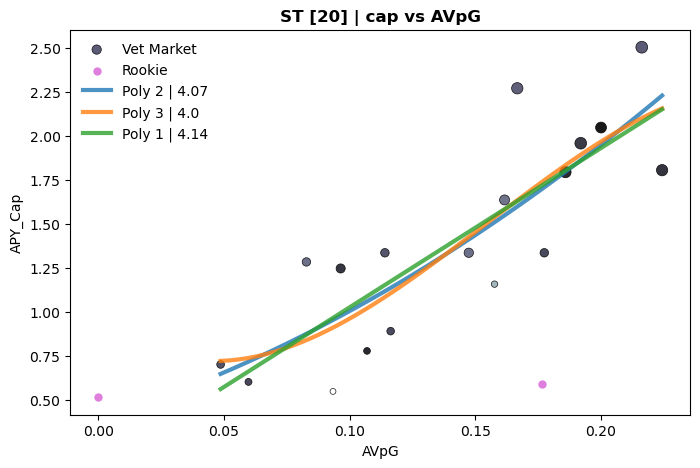

In [198]:
cutoff = 20
position = 'ST'
x_col = 'AV_percentile'
x_col = 'AVpG'



d = market_tables[position].copy().head(cutoff)
vet = d[d.Drafted!=2023]

fig, ax = plt.subplots(figsize=(8,5), dpi=100)
sns.scatterplot(vet, y='APY_Cap', x=x_col, hue='% Guaranteed', palette='bone',
        size='Total Value', legend=False, alpha=0.9, 
        edgecolor='k', linewidth=0.5, ax=ax)
ax.scatter(data = d[~d.index.isin(vet.index)], x=x_col, y='APY_Cap', 
            color='m', alpha=0.5, linewidths=0)  

x = np.linspace(vet[x_col].min(), vet[x_col].max())
leg_text = []
for deg in [2,3,1]:
    px = np.polyfit(vet[x_col], vet.APY_Cap, deg,  full=True)
    poly_fit = (px[0],px[1][0], deg) 
    ax.plot(x, np.poly1d(poly_fit[0])(x),'-', linewidth=3, alpha=0.8)
    leg_text.append(f'Poly {deg} | {round(100*px[1][0]/np.sum(vet.APY_Cap**2),2)}')
plt.legend(['Vet Market', 'Rookie']+leg_text, frameon=False)
plt.title(f'{position} [{cutoff}] | cap vs {x_col}', fontweight='bold')

plt.show()

### statsmodels api not used here

In [ ]:
# statsmodels api, see other notebook for exampels

# mx = sm.add_constant(vet.AV_percentile)
# # Gamma warning if not initialized with log link: sm.families.links.Log()
# fx1 = sm.GLM(vet.APY_Cap, mx, family=sm.families.Gamma()).fit()
# fx2 = sm.GLM(vet.APY_Cap, mx, family=sm.families.Poisson()).fit()
# fx3 = sm.GLM(vet.APY_Cap, mx, family=sm.families.InverseGaussian()).fit()

# ax.plot(x, fx1.predict(sm.add_constant(x)),'-',)
# ax.plot(x, fx2.predict(sm.add_constant(x)),'-',)
# ax.plot(x, fx3.predict(sm.add_constant(x)),'-',)

# f'{str(fx1.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx1.resid_response**2)/sq_resp,2)}',
# f'{str(fx2.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx2.resid_response**2)/sq_resp,2)}',
# f'{str(fx3.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx3.resid_response**2)/sq_resp,2)}', 

# loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False)